In [1]:
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import h5py
import numpy as np
import torch
import torch.nn as nn
from math import sqrt
import matplotlib.pyplot as plt

In [2]:
device = "cpu"
if(torch.cuda.is_available()):
    device = "cuda"; print('---device:cuda---')

In [3]:
#dic with energies in eV of elements
dic={ 'Ca':3692,'Mn':5900,'Fe':6405,'Cu':8046,'Au':9713,'Hg':9989,'Pb':10551,'Sr':14165}
num_elements=len(dic)
#load h5 cubes panagia, jesus and hand
f = h5py.File('C:/Users/ioann/Documents/GitHub/Hyperspectral-Image-Analysis/data/panagia1_mm.h5', 'r')
dset=f['dataset']
dEset=f['energies']
spectra_p=np.array(dset)
energies=np.array(dEset)
f.close()

f = h5py.File('C:/Users/ioann/Documents/GitHub/Hyperspectral-Image-Analysis/data/christ.h5', 'r')
dset=f['dataset']
spectra_c=np.array(dset)
f.close()

f = h5py.File('C:/Users/ioann/Documents/GitHub/Hyperspectral-Image-Analysis/data/hand.h5', 'r')
dset=f['dataset']
spectra_h=np.array(dset)
f.close()



In [4]:
#set the number of channels to cut
channels=100
#dimensions of images
rows_p=41
cols_p=65
rows_c=31
cols_c=46
rows_h=41
cols_h=21

#cut first #channels
spectra_p = spectra_p.astype(np.float32)
spectra_c = spectra_c.astype(np.float32)
spectra_h = spectra_h.astype(np.float32)
spectra_p=np.delete(spectra_p,np.s_[:channels],1)
spectra_c=np.delete(spectra_c,np.s_[:channels],1)
spectra_h=np.delete(spectra_h,np.s_[:channels],1)

energies=np.delete(energies,np.s_[:channels])


In [5]:
#Full width at half maximum     
def fwhm(ev):
    return sqrt(2.47*ev+4400)

In [6]:
X_p=torch.tensor(spectra_p)
X_c=torch.tensor(spectra_c)
X_h=torch.tensor(spectra_h)

In [7]:
#Calculate min and max channel of each elements in order to determine the range of interest
key_list=list(dic.keys())
min_ch=[]
max_ch=[]
min_roi_all=[]
max_roi_all=[]
for element in dic:
    min_roi=(dic[element]-fwhm(dic[element])/2)
    min_roi_all.append(min_roi)
    max_roi=(dic[element]+fwhm(dic[element])/2)
    max_roi_all.append(max_roi)
    min_ch.append(int((min_roi+960)/20)-channels)
    max_ch.append(int((max_roi+960)/20)-channels)

#Create target vectors according to ROI
y_p=np.zeros([len(spectra_p),num_elements])
for i in range(len(spectra_p)):
    for j in range(len(key_list)):
        y_p[i][j]=np.sum(np.sum(spectra_p[i,min_ch[j]:max_ch[j]]))
y_c=np.zeros([len(spectra_c),num_elements])
for i in range(len(spectra_c)):
    for j in range(len(key_list)):
        y_c[i][j]=np.sum(np.sum(spectra_c[i,min_ch[j]:max_ch[j]]))
y_h=np.zeros([len(spectra_h),num_elements])
for i in range(len(spectra_h)):
    for j in range(len(key_list)):
        y_h[i][j]=np.sum(np.sum(spectra_h[i,min_ch[j]:max_ch[j]]))
#convert target vectors to tensors
y_p, y_c, y_h = torch.tensor(y_p), torch.tensor(y_c), torch.tensor(y_h)


In [8]:
class CustomDataset(Dataset):    
    def __init__(self, XY_train, XY_test):
        self.isTrain = True 
        self.X_train = XY_train[0]
        self.y_train = XY_train[1]
        self.X_test = XY_test[0]
        self.y_test = XY_test[1]
        
    def setTrain(self,train):
        self.isTrain = train

    def __getitem__(self, index):
        if(self.isTrain):
            return self.X_train[index], self.y_train[index]
        return self.X_test[index], self.y_test[index]
    
    def __len__(self):
        if(self.isTrain):
            return self.X_train.shape[0]
        return self.X_test.shape[0]

In [9]:
# Hyper-parameters 
input_size = len(spectra_p[0])
hidden_size = 100
output_size = len(key_list)
num_epochs = 500
batch_size = 32
learning_rate = 0.001
shuffle=True

In [10]:
dataSet = CustomDataset(
    (X_p, y_p), (X_c, y_c)
)
dataLoader = DataLoader(
    dataset=dataSet, 
    batch_size=batch_size, 
    shuffle=shuffle
)

In [11]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [12]:
model = NeuralNet(input_size, hidden_size, output_size).to(device)

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [14]:
for epoch in range(num_epochs):
    ### TRAINING ### 
    dataSet.setTrain(True)
    for idx, (x_in, y_in) in enumerate(dataLoader):
        optimizer.zero_grad()
        
        x_in, y_in = x_in.to(device), y_in.to(device) 
        y_in = y_in.float()
        # Forward pass
        outputs = model(x_in)
        loss = criterion(outputs, y_in)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        
    print ("Epoch: "+str(epoch+1)+" -- Loss:"+ str(loss.item()))

Epoch: 1 -- Loss:1230.5577392578125
Epoch: 2 -- Loss:994.619140625
Epoch: 3 -- Loss:452.4197082519531
Epoch: 4 -- Loss:97.29721069335938
Epoch: 5 -- Loss:43.96974563598633
Epoch: 6 -- Loss:71.00723266601562
Epoch: 7 -- Loss:59.1263427734375
Epoch: 8 -- Loss:35.463348388671875
Epoch: 9 -- Loss:30.11448097229004
Epoch: 10 -- Loss:108.86748504638672
Epoch: 11 -- Loss:41.93666076660156
Epoch: 12 -- Loss:40.86812973022461
Epoch: 13 -- Loss:36.39378356933594
Epoch: 14 -- Loss:16.449968338012695
Epoch: 15 -- Loss:38.66699981689453
Epoch: 16 -- Loss:36.8616943359375
Epoch: 17 -- Loss:38.5931510925293
Epoch: 18 -- Loss:28.254430770874023
Epoch: 19 -- Loss:25.983572006225586
Epoch: 20 -- Loss:44.335514068603516
Epoch: 21 -- Loss:23.748918533325195
Epoch: 22 -- Loss:21.76079559326172
Epoch: 23 -- Loss:16.66008186340332
Epoch: 24 -- Loss:43.7810173034668
Epoch: 25 -- Loss:23.25678062438965
Epoch: 26 -- Loss:11.443479537963867
Epoch: 27 -- Loss:25.154773712158203
Epoch: 28 -- Loss:15.14970397949218

In [20]:
a=model(X_c).detach().numpy()

In [21]:
a_c=a.reshape(rows_c,cols_c,8)

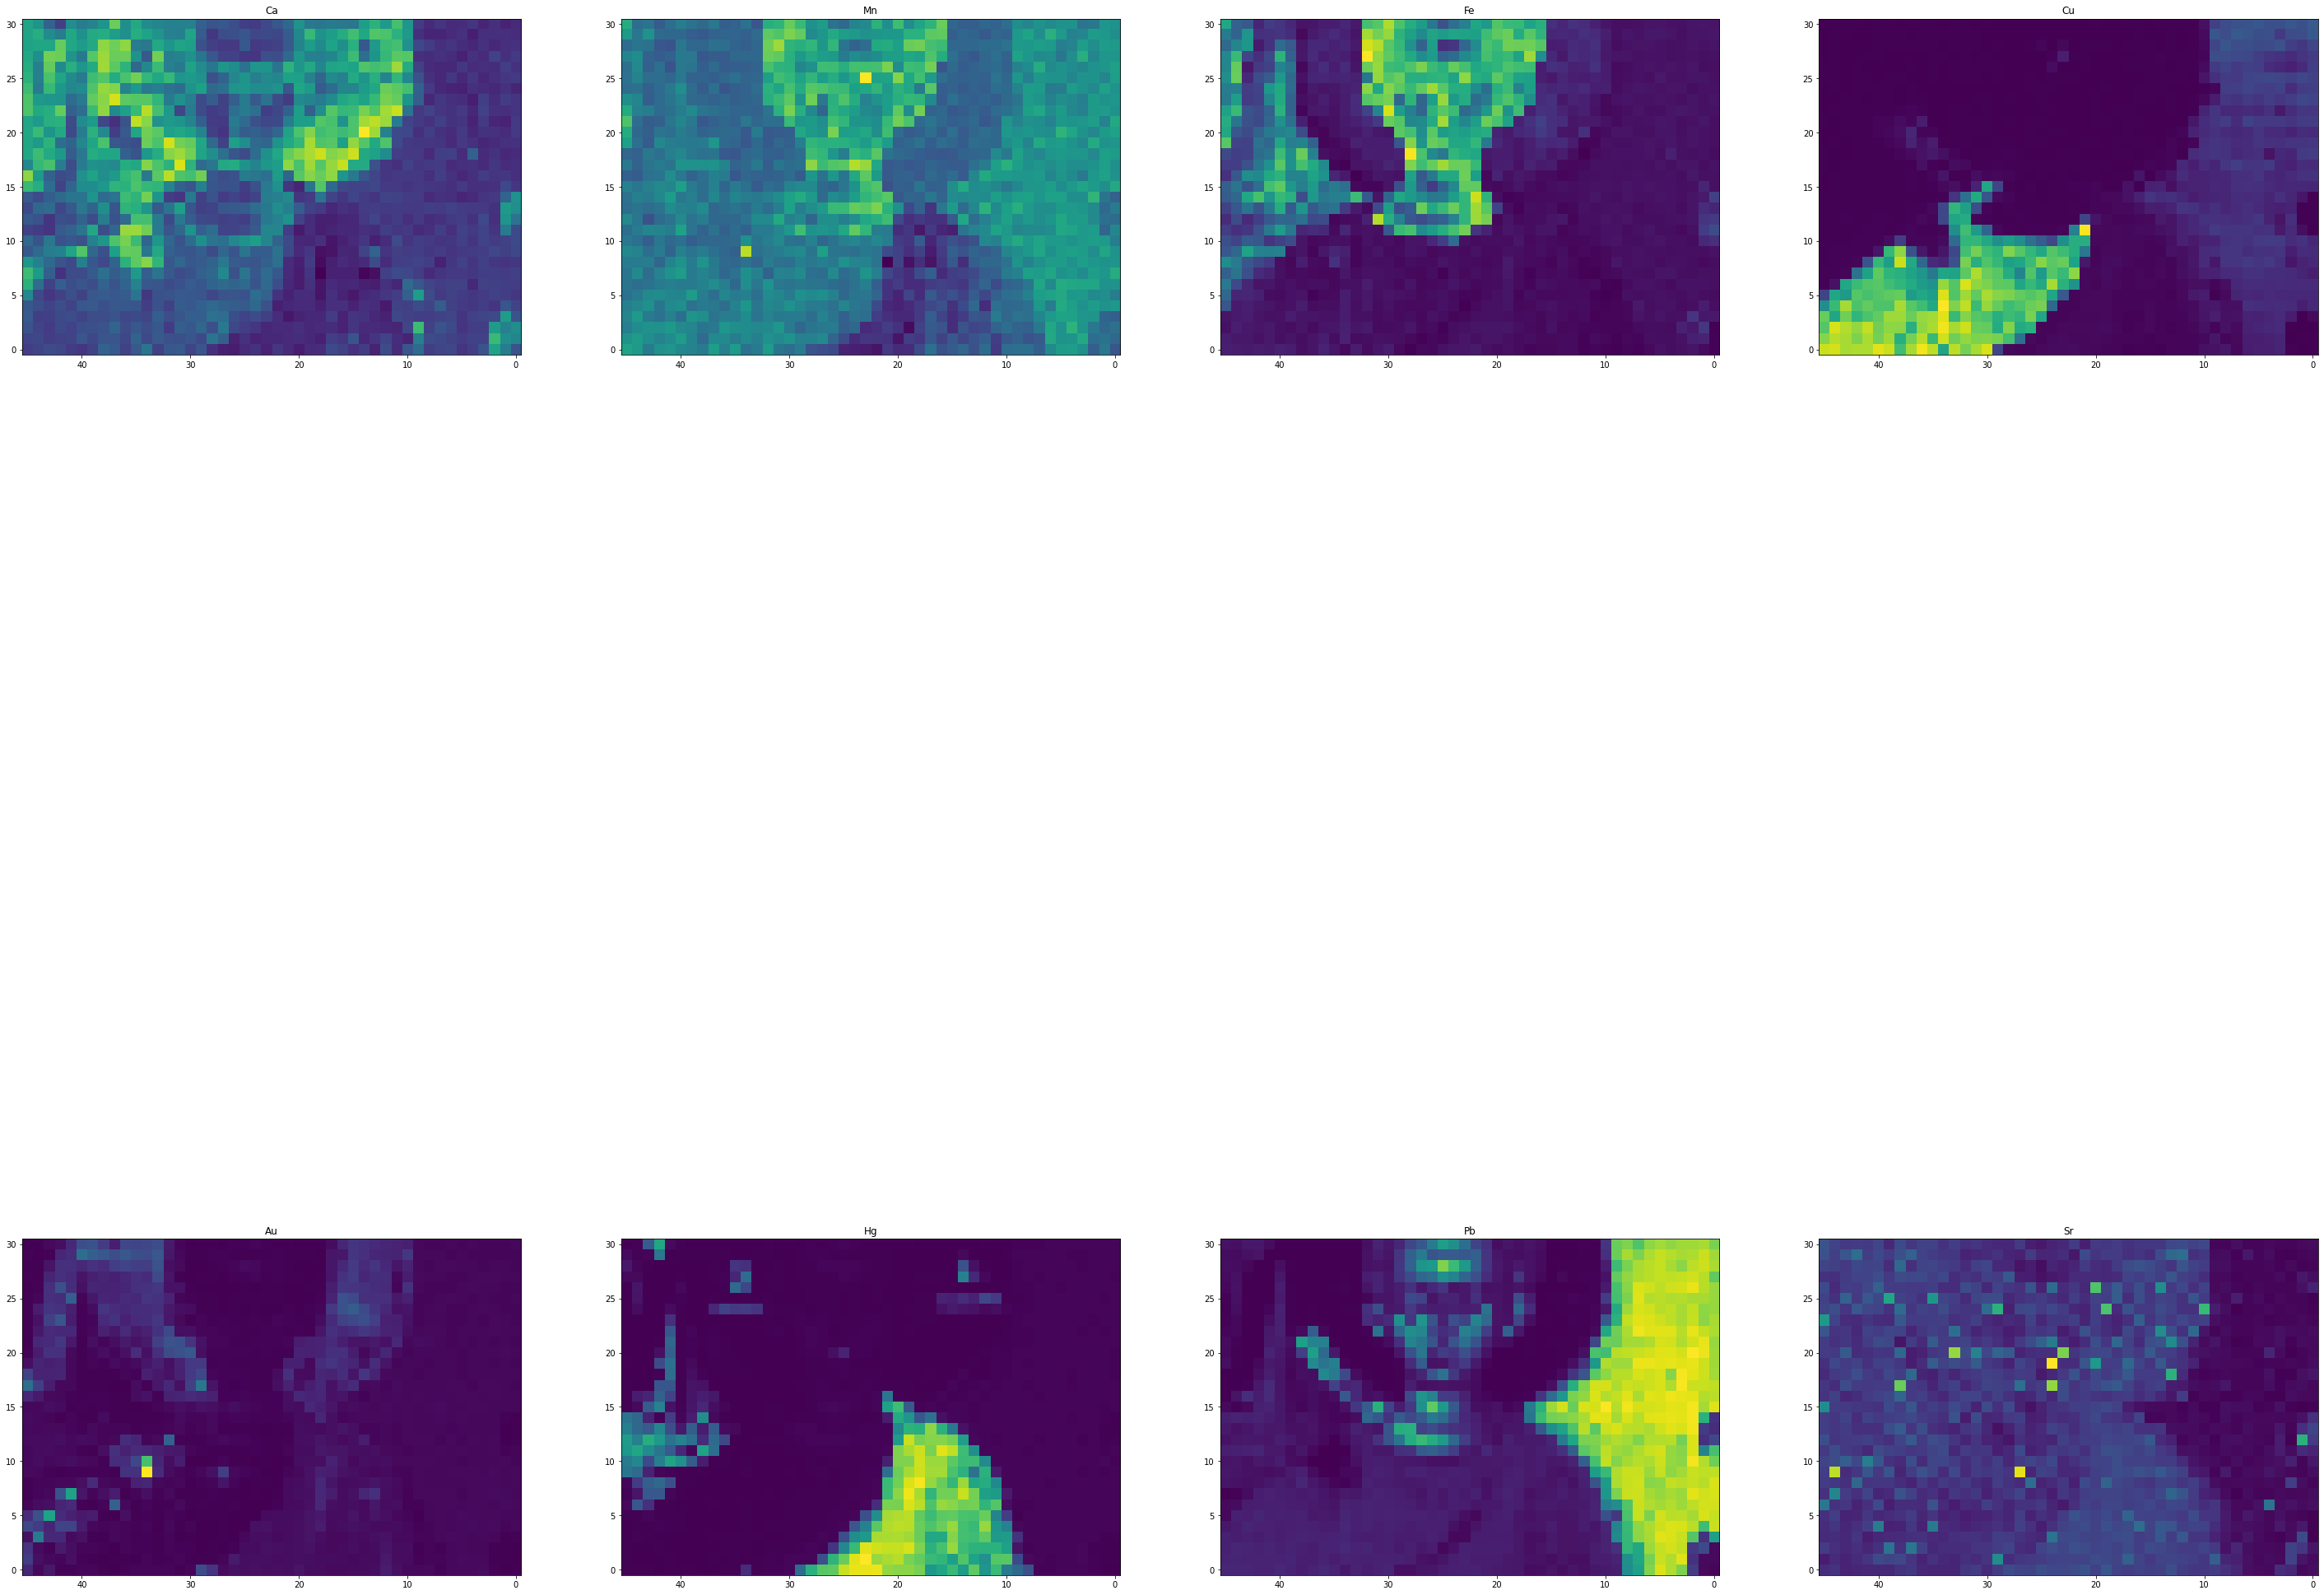

In [22]:

fig, ax = plt.subplots(nrows=2,ncols=4)
fig.set_figheight(50)
fig.set_figwidth(50)
k=0
for i in range(2):
    for j in range(4):
        ax[i][j].imshow(a_c[:,:,k])
        ax[i][j].invert_yaxis()
        ax[i][j].invert_xaxis()
        ax[i][j].title.set_text(key_list[k])
        k+=1

In [18]:
#torch.save(model,'trained_model')

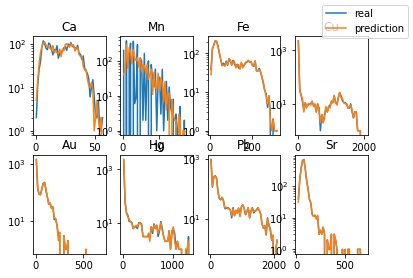

In [19]:

y_detached=y_p.detach().numpy()
fig, ax = plt.subplots(nrows=2,ncols=4)
r=0
c=0
for el in range(len(key_list)):
    min_el=np.min(y_detached[:,el])
    max_el=np.max(y_detached[:,el])
    #print(key_list[el],min_el,max_el)
    step=(max_el-min_el)/50
    limits=[x for x in np.arange(min_el,max_el,step)]
    x_ax=[]
    for x in range(len(limits)-1):
        x_ax.append((limits[x]+limits[x+1])/2.)
    counts=np.zeros(len(limits)-1)
    counts_pr=np.zeros(len(limits)-1)
    for i in range(len(y_detached)):
        for k in range(len(counts)):
            if y_detached[i,el]>=limits[k] and y_detached[i,el]<=limits[k+1] :
                counts[k]+=1
            if a[i,el]>=limits[k] and a[i,el]<=limits[k+1] :
                counts_pr[k]+=1
    ax[r][c].set_yscale('log')
    ax[r][c].plot(x_ax,counts)
    ax[r][c].plot(x_ax,counts_pr)
    ax[r][c].title.set_text(key_list[el])
    c+=1
    if c==4:
        c=0
        r+=1
fig.legend(['real','prediction'])